# Paper Framework

<img src="./Resources/3Sigma-STR framework.png" alt="3Sigma-STR Framework" width="800"/>

In [34]:
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Reshape, Conv1D, GlobalMaxPooling1D, Input

## Parameters

In [35]:
data_folder = "./Data"
results_folder = "./Results"

## Methods - Functions

### Data Preprocessing

#### Analysis + Cleaning


In [36]:
def concat_data(data_folder):
    """
    Concatenate CSV files from a specified folder and year into a single DataFrame.

    Args:
        data_folder (str): Path to the folder containing the CSV files.
        year (int): Year to filter the CSV files by.

    Returns:
        pd.DataFrame: DataFrame containing concatenated data from the specified year.
    """
    
    data = pd.DataFrame()
    for file in Path(data_folder).rglob('*.csv'):
        df = pd.read_csv(file)
        data = pd.concat([data, df])

    data = data.sort_values(by="Date/Time (LST)").reset_index(drop=True)

    return data

In [37]:
def analyze_data(data, time_col="Date/Time (LST)", rain_col="Precip. Amount (mm)", plot=True):
    """
    Analyze rainfall data by checking for missing values, calculating basic statistics, and plotting the data.

    Parameters:
        rainfall_data (pd.DataFrame): DataFrame containing the rainfall data.
        time_col (str): Name of the column containing timestamps.
        rain_col (str): Name of the column containing precipitation amounts.

    Returns:
        dict: Dictionary containing basic statistics and missing values information.
    """
    
    data[time_col] = pd.to_datetime(data[time_col])

    # Check for missing values
    missing_values = data[rain_col].isnull().sum()
    print(f"Number of missing values in {rain_col}: {missing_values}")

    # Calculate basic statistics
    stats = data[rain_col].describe()
    print(f"Basic statistics for {rain_col}:\n{stats}")

    if plot:
        # Plot the data
        data.plot(x=time_col, y=rain_col, title='Rainfall Data Over Time')

    # Plot missing values
    if missing_values > 0:
        missing_data = data[data[rain_col].isnull()].fillna(0)
        missing_data.plot(x=time_col, y=rain_col, kind='scatter', color='red', title='Missing Values in Rainfall Data')


In [38]:
def clean_data(data, time_col, rain_col, remove_outliers=True):
    """
    Clean the data by removing unnecessary columns, renaming columns, and optionally removing outliers.

    Args:
        data (pd.DataFrame): DataFrame containing the data to be cleaned.
        time_col (str): Name of the column containing timestamps.
        rain_col (str): Name of the column containing rainfall amounts.
        remove_outliers (bool): Whether to remove outliers from the data.

    Returns:
        pd.DataFrame: DataFrame containing cleaned data.
    """
    
    # Set the index to the timestamp column
    data[time_col] = pd.to_datetime(data[time_col])
    data.set_index(time_col, inplace=True)
    data = data.asfreq('h')

    # Drop nan and zero rainfall values
    data = data.dropna(subset=[rain_col])

    if remove_outliers:
        # Remove outliers using the IQR method
        Q1 = data[data[rain_col] > 0][rain_col].quantile(0.25)
        Q3 = data[data[rain_col] > 0][rain_col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        upper_bound = Q3 + 29 * IQR

        # Identify outliers
        outliers = data[data[rain_col] > upper_bound]
        print("Upper Bound for Outliers:", upper_bound)
        print("Number of Outliers:", len(outliers),"\n")

        # Remove outliers  
        data = data[data[rain_col] <= upper_bound]

    return data

In [39]:
def inference(data, rain_col="Precip. Amount (mm)", using_decompose=True):
    """
    Analyze rainfall data by calculating the correlation matrix, plotting a heatmap,
    and performing the Augmented Dickey-Fuller test for stationarity.

    Parameters:
        rainfall_data (pd.DataFrame): DataFrame containing the rainfall data.
        time_col (str): Name of the column containing timestamps.
        rain_col (str): Name of the column containing precipitation amounts.

    Returns:
        dict: Results of the Augmented Dickey-Fuller test.
    """

    # Correlation matrix "check correlation between features" 
    numeric_data = data.select_dtypes(include=[np.number])
    corr_matrix = numeric_data.corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, annot_kws={"size": 10, "weight": "bold"})

    # Augmented Dickey-Fuller test for stationarity
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data[rain_col])
    print("pvalue = ", pvalue, "if above 0.05, data is not stationary")

    # Seasonality
    ## Boxplots General Patterns "Yearly & Monthly"
    data['year'] = [h.year for h in data.index]
    data['month'] = [h.strftime('%b') for h in data.index]
    years = data['year'].unique()
    months = data['month'].unique()
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    sns.boxplot(x="year", y=rain_col, data=data, ax=axs[0])
    sns.boxplot(x="month", y=rain_col, data=data, ax=axs[1])
    axs[0].set_title('Boxplots of Rainfall Amounts')
    plt.show()
    
    if using_decompose:
        ## Using seasonal_decompose
        decomposed = seasonal_decompose(data[rain_col], model='additive', period=24*365)

        plt.figure(figsize=(12, 10))
        plt.subplot(411)
        plt.plot(data[rain_col], label='Original', color='blue')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(decomposed.trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(decomposed.seasonal, label='Seasonal', color='blue')
        plt.legend(loc='best')
        plt.show()
 
    autocorrelation_plot(data[rain_col])
    plt.show()    

In [40]:
def inference_categorical(data, rain_col="Rain Intensity"):
    """
    Analyze categorical rainfall data after sigma chart by calculating the frequency distribution,
    plotting a heatmap of the correlation matrix, and visualizing the data.

    Parameters:
        data (pd.DataFrame): DataFrame containing the rainfall data.
        time_col (str): Name of the column containing timestamps.
        rain_col (str): Name of the column containing categorical rainfall intensity.

    Returns:
        dict: Frequency distribution of the categorical data.
    """
    
    # Calculate basic statistics
    stats = data[rain_col].describe()
    print(f"Basic statistics for {rain_col}:\n{stats}\n")

    # Frequency distribution of categorical data
    freq_dist = data[rain_col].value_counts(normalize=True)
    print(f"Frequency distribution of {rain_col}:\n{freq_dist}")

    # Plot frequency distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freq_dist.index, y=freq_dist.values)
    plt.title(f'Frequency Distribution of {rain_col}')
    plt.xlabel(rain_col)
    plt.ylabel('Proportion')
    plt.show()


    # Seasonality analysis
    data['year'] = data.index.year
    data['month'] = data.index.strftime('%b')
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    sns.countplot(x="year", hue=rain_col, data=data, ax=axs[0])
    sns.countplot(x="month", hue=rain_col, data=data, ax=axs[1])
    axs[0].set_title('Yearly Distribution of Rainfall Intensity')
    axs[1].set_title('Monthly Distribution of Rainfall Intensity')
    plt.show()

#### Transformation (Sigma Limits + Events Discretization)

In [41]:
def sigma_limits(data, rain_col, sigma=3):
    """
    Calculate the upper and lower sigma limits for the data and classify rain intensity.

    Args:
        data (pd.DataFrame): DataFrame containing the data.
        rain_col (str): Name of the column containing rainfall amounts.
        sigma (int): Number of standard deviations to use for the limits.

    Returns:
        pd.DataFrame: DataFrame with an additional column classifying rain intensity.
    """
    
    # Calculate the mean and standard deviation of the data
    # mean = data[rain_col].mean()
    # std_dev = data[rain_col].std()

    mean = data[data[rain_col] > 0][rain_col].mean()
    std_dev = data[data[rain_col] > 0][rain_col].std()

    # Create a list of sigma limits
    sigma_limits = [mean + i * std_dev for i in range(1, sigma + 1)]

    # Initialize the Rain Intensity column with 'Low'
    data['Rain Intensity'] = f'{sigma} sigma'

    # Classify data points based on sigma limits, skipping the first limit
    for i, limit in enumerate(reversed(sigma_limits)):
        data.loc[data[rain_col] <= limit, 'Rain Intensity'] = f'{sigma - i} sigma'

    data.loc[data[rain_col] == 0, 'Rain Intensity'] = 'No-Rainfall'

    return data, sigma_limits

### Machine Learning
In this section we would use machine learning for classification

#### LSTM

In [42]:
def train_lstm_model(rainfall_data, target_col, sequence_length=24, test_size=0.3, epochs=20, batch_size=32):
    """
    Train an LSTM model on categorical rainfall data.

    Parameters:
        rainfall_data (pd.DataFrame): DataFrame containing the rainfall data.
        target_col (str): Name of the target column (categorical rainfall levels).
        sequence_length (int): Length of the sequences for LSTM input.
        test_size (float): Proportion of the data to be used as the test set.
        epochs (int): Number of epochs to train the model.
        batch_size (int): Batch size for training.

    Returns:
        model (Sequential): Trained LSTM model.
        history (History): Training history.
        label_encoder (LabelEncoder): Label encoder for decoding predictions.
    """

    # Encode categorical rainfall labels
    label_encoder = LabelEncoder().fit(rainfall_data[target_col])
    encoded_sequences = label_encoder.transform(rainfall_data[target_col])

    # Function to create sequences
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])  # Use the encoded rainfall category
            y.append(data[i + seq_length])   # Predict the next value
        return np.array(X), np.array(y)

    # Prepare sequences for LSTM
    X, y = create_sequences(encoded_sequences, sequence_length)

    # Convert y to categorical
    y = to_categorical(y, num_classes=len(label_encoder.classes_))

    # Split into train and test sets
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=False)

    # Compute Class Weights
    y_train_labels = np.argmax(y_train, axis=1)  # Convert one-hot back to single labels
    classes = np.unique(y_train_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Computed Class Weights:", class_weight_dict)

    vocab_size = len(label_encoder.classes_)
    # Build LSTM model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=1),
        LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(y.shape[1], activation='softmax')  # Output layer for classification
    ])

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(name='precision'), 
                                                                              tf.keras.metrics.Recall(name='recall')])

    # Train model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), class_weight=class_weight_dict)
    
    return model, history, label_encoder, (X_test, y_test)


def plot_training_metrics(history):
        """
        Plot training loss, precision, and recall from the training history.

        Parameters:
            history (History): Training history object containing metrics.
        """
        fig = plt.figure(figsize=(13, 4))

        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(history.history['precision'], label='Training Precision')
        plt.plot(history.history['val_precision'], label='Validation Precision')
        plt.title('Model Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(history.history['recall'], label='Training Recall')
        plt.plot(history.history['val_recall'], label='Validation Recall')
        plt.title('Model Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        return fig

def model_confusion_matrix(model, X_test, y_test, label_encoder, hot_encoding=True):
    """
    Evaluate the model's performance and display confusion matrix.

    Parameters:
        model (Sequential): Trained LSTM model.
        X_test (np.ndarray): Test data features.
        y_test (np.ndarray): Test data labels (one-hot encoded).
        label_encoder (LabelEncoder): Label encoder for decoding predictions.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    if hot_encoding:
        y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoding to class labels
        y_true = np.argmax(y_test, axis=1)
    else:
        y_pred_classes, y_true = y_pred, y_test

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    plt.title("Confusion Matrix for Rainfall Prediction")

    return fig

def plot_rainfall_category_predictions(model, testing_data, label_encoder, horizon = 24, event_index = 0, hot_encoding=True):
    """
    Generate and return a rainfall-category time-series plot.

    Parameters:
        model (keras.Model): Trained classifier with a .predict() method.
        testing_data (tuple[np.ndarray, np.ndarray]): `X_test`, `y_test` — features and one-hot targets for all test samples.
        label_encoder (LabelEncoder): Fitted encoder to convert class indices ↔ string labels.
        horizon (int): Number of consecutive time steps to plot, default 24.
        event_index (int): Starting index of the plotted window within the test set, default 0.
    """
    
    # Slice test window
    X_test, y_test = testing_data
    X_win = X_test[event_index : event_index + horizon]
    y_win = y_test[event_index : event_index + horizon]

    # Predictions → class indices
    y_pred_probs = model.predict(X_win)
    if hot_encoding:
        y_pred_cls = np.argmax(y_pred_probs, axis=1)
        y_true_cls = np.argmax(y_win, axis=1)
    else:
        y_pred_cls, y_true_cls = y_pred_probs, y_win

    # Convert indices → categorical labels
    pred_labels = label_encoder.inverse_transform(y_pred_cls)
    true_labels = label_encoder.inverse_transform(y_true_cls)

    # Assemble DataFrame for convenience
    df = pd.DataFrame(
        {"Time Step": range(horizon), "Actual": true_labels, "Predicted": pred_labels}
    )

    # Ordering & numeric mapping for plotting
    # category_order = list(label_encoder.classes_)
    category_order = ["No-Rainfall", "1 sigma", "2 sigma", "3 sigma"]
    cat_map = {cat: idx for idx, cat in enumerate(category_order)}
    df["Actual"] = pd.Categorical(df["Actual"], categories=category_order, ordered=True)
    df["Predicted"] = pd.Categorical(
        df["Predicted"], categories=category_order, ordered=True
    )

    actual_num = df["Actual"].map(cat_map)
    pred_num = df["Predicted"].map(cat_map)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df["Time Step"], pred_num, label="Predicted", color="red")
    ax.plot(df["Time Step"], actual_num, label="Actual", color="black")

    ax.set(
        xlabel="Time (hr)",
        ylabel="Rainfall Category",
        yticks=range(len(category_order)),
        yticklabels=category_order,
    )
    ax.legend()
    ax.grid(linestyle="--")
    plt.tight_layout()

    return fig

#### CNN

In [43]:
def train_cnn_model(rainfall_data, target_col, sequence_length=24, test_size=0.3, epochs=20, batch_size=32):
    """
    Train a CNN model on categorical rainfall data.

    Parameters:
        rainfall_data (pd.DataFrame): DataFrame containing the rainfall data.
        target_col (str): Name of the target column (categorical rainfall levels).
        sequence_length (int): Length of the input sequences.
        test_size (float): Fraction of data to use for testing.
        epochs (int): Number of training epochs.
        batch_size (int): Training batch size.

    Returns:
        model (Sequential): Trained CNN model.
        history (History): Training history.
        label_encoder (LabelEncoder): Fitted label encoder.
        (X_test, y_test): Test dataset for evaluation.
    """
    
    # Encode categorical target
    label_encoder = LabelEncoder().fit(rainfall_data[target_col])
    encoded = label_encoder.transform(rainfall_data[target_col])

    # Create sequences
    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i + seq_len])
            y.append(data[i + seq_len])
        return np.array(X), np.array(y)

    X, y = create_sequences(encoded, sequence_length)
    y = to_categorical(y, num_classes=len(label_encoder.classes_))

    # Reshape for Conv1D input: (samples, timesteps, channels)
    X = X[..., np.newaxis]  # shape: (n_samples, seq_len, 1)

    # Split into train/val/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # Compute class weights
    y_train_labels = np.argmax(y_train, axis=1)
    classes = np.unique(y_train_labels)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_labels)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("Computed Class Weights:", class_weight_dict)

    vocab_size = len(label_encoder.classes_)
    # Build CNN model
    model = tf.keras.models.Sequential([
        Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(sequence_length, 1)),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        GlobalMaxPooling1D(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(y.shape[1], activation="softmax")
    ])

    # Compile model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict
    )

    return model, history, label_encoder, (X_test, y_test)

#### Random Forest

In [44]:
def train_tree_model(rainfall_data, target_col, sequence_length=24, test_size=0.3):
    """
    Train a Random Forest classifier on categorical rainfall data using lagged features.

    Args:
        rainfall_data (pd.DataFrame): DataFrame containing the rainfall data.
        target_col (str): Name of the target column (categorical rainfall levels).
        sequence_length (int, optional): Number of lagged time steps to use as features. Defaults to 5.
        test_size (float, optional): Fraction of data to use for testing. Defaults to 0.3.

    Returns:
        model (RandomForestClassifier): Trained Random Forest model.
        label_encoder (LabelEncoder): Fitted label encoder for the target.
        (X_test, y_test) (tuple): Test features and true labels.
        y_pred (np.ndarray): Predicted labels for the test set.
    """
    
    # Encode categorical target
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(rainfall_data[target_col])
    
    # Create sequences
    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i + seq_len])  # lag features
            y.append(data[i + seq_len])    # target: next step
        return np.array(X), np.array(y)

    X, y = create_sequences(encoded, sequence_length)
    
    # Split into train/val/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    
    # Fit Random Forest
    model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return model, label_encoder, (X_test, y_test)

## Methods - Calling

### Data Analysis

#### Raw Data - Rainfall Hourly

Number of missing values in Precip. Amount (mm): 26335
Basic statistics for Precip. Amount (mm):
count    87617.000000
mean         0.098270
std          0.676052
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         48.800000
Name: Precip. Amount (mm), dtype: float64


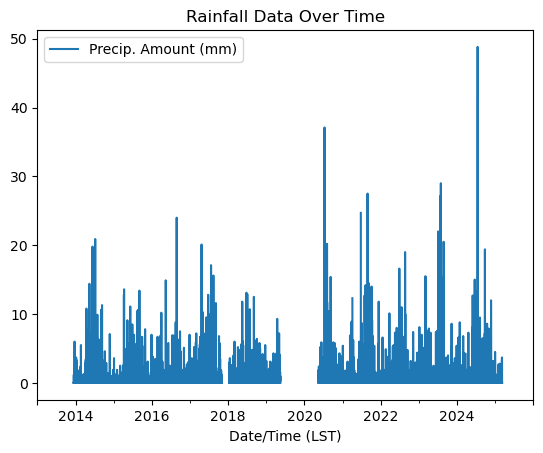

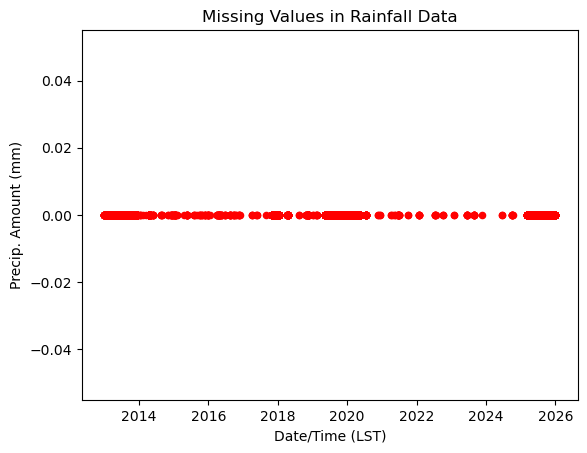

In [45]:
# Initialize event_data as an empty DataFrame
rainfall_data = concat_data(data_folder)
analyze_data(rainfall_data, time_col="Date/Time (LST)", rain_col="Precip. Amount (mm)")

Upper Bound for Outliers: 33.2
Number of Outliers: 2 

pvalue =  0.0 if above 0.05, data is not stationary


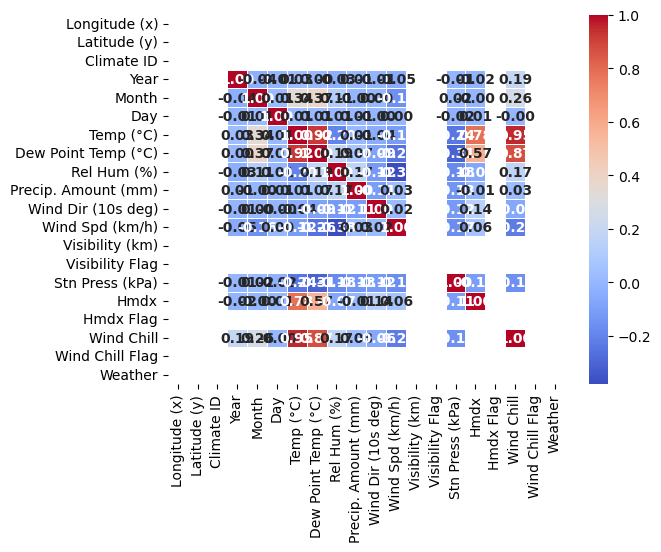

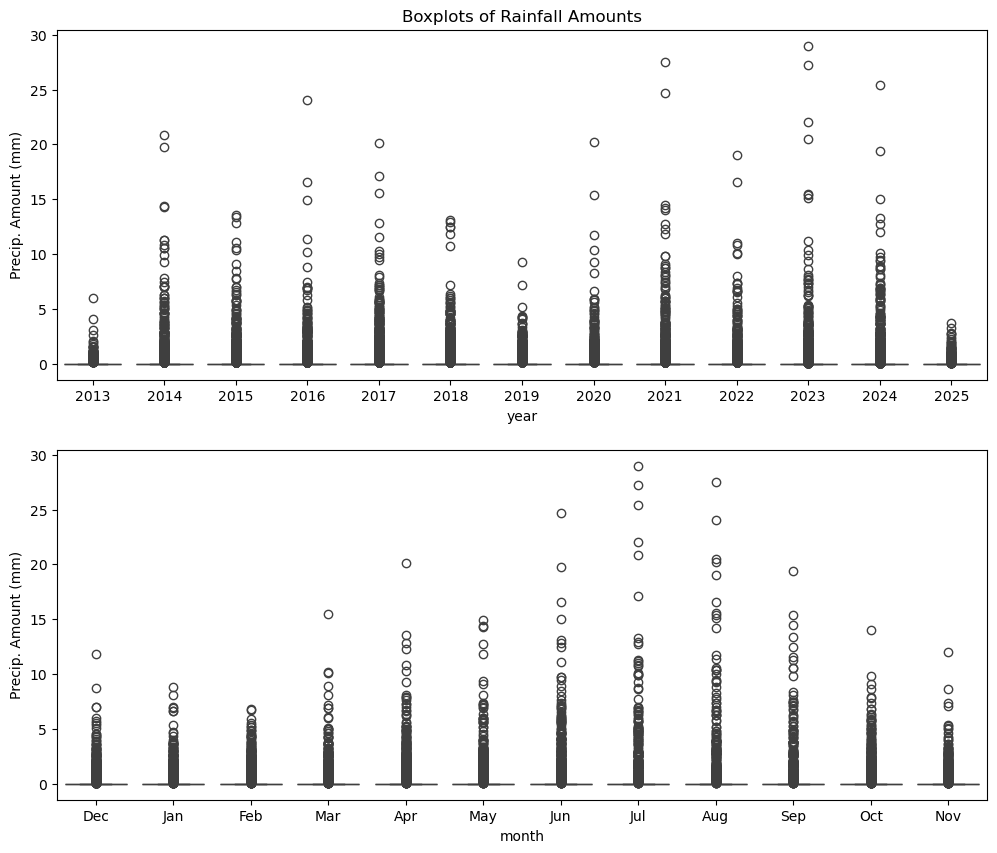

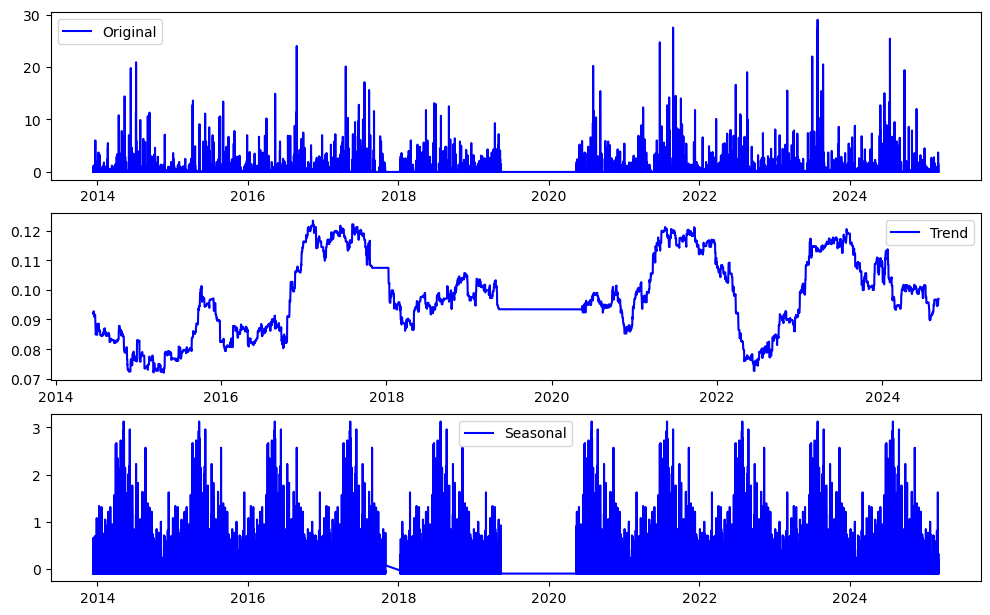

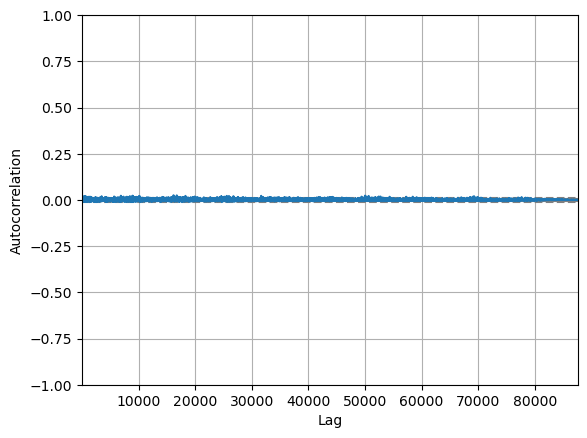

In [46]:
clean_rainfall_data = clean_data(rainfall_data, time_col="Date/Time (LST)", rain_col="Precip. Amount (mm)", remove_outliers=True)
inference(clean_rainfall_data, rain_col="Precip. Amount (mm)")

#### Raw Data - Rainfall Hourly - With no Zeros

Number of missing values in Precip. Amount (mm): 0
Basic statistics for Precip. Amount (mm):
count    7132.000000
mean        1.207249
std         2.067983
min         0.100000
25%         0.200000
50%         0.600000
75%         1.300000
max        48.800000
Name: Precip. Amount (mm), dtype: float64


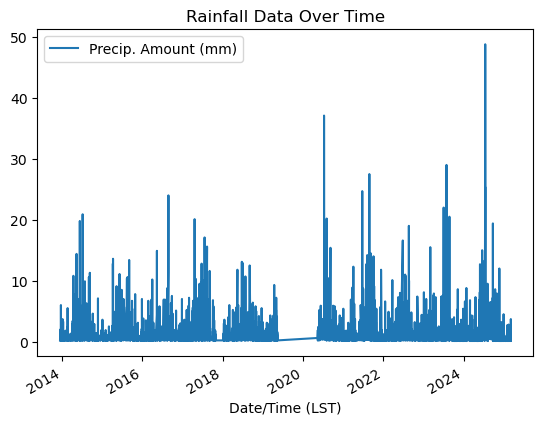

In [47]:
# Initialize event_data as an empty DataFrame
rainfall_data = concat_data(data_folder)
rainfall_data = rainfall_data[rainfall_data["Precip. Amount (mm)"] > 0]
analyze_data(rainfall_data, time_col="Date/Time (LST)", rain_col="Precip. Amount (mm)")

Upper Bound for Outliers: 33.2
Number of Outliers: 2 

pvalue =  2.0763494316140706e-14 if above 0.05, data is not stationary


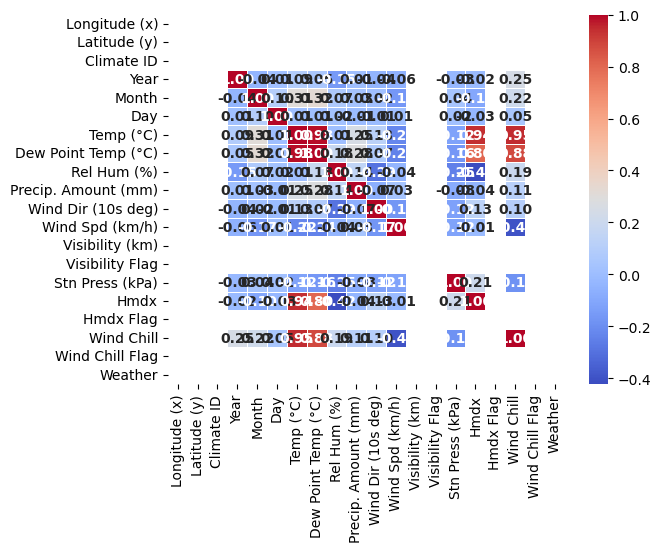

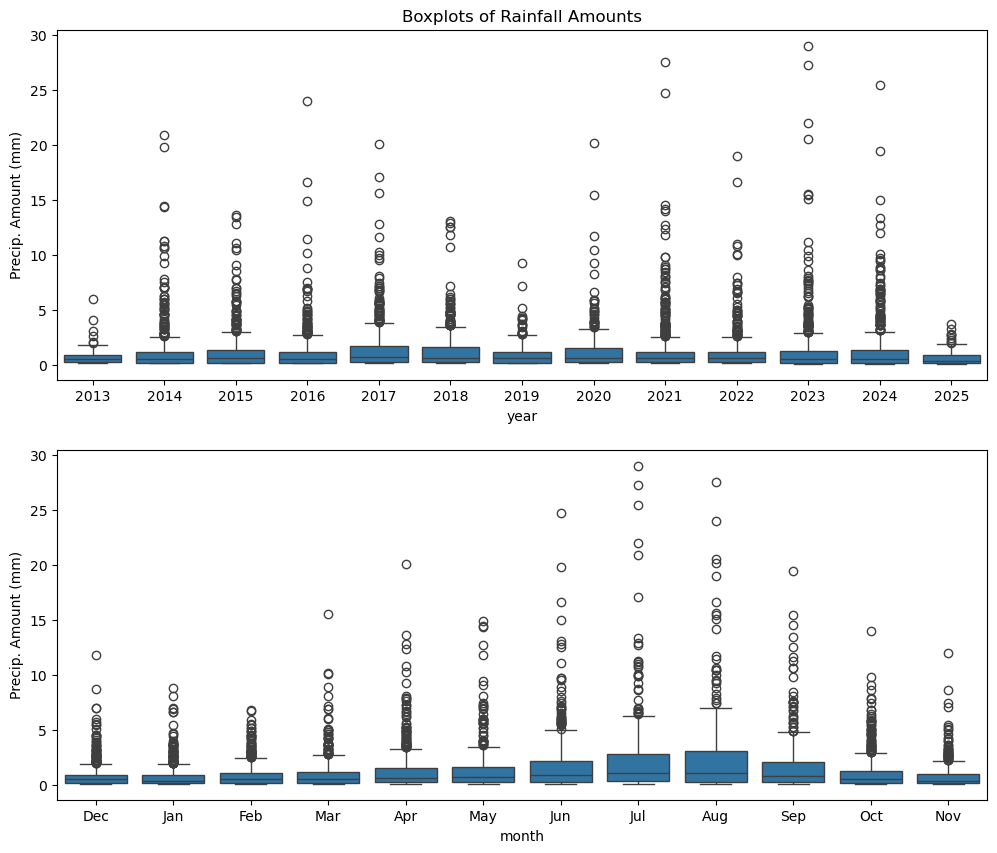

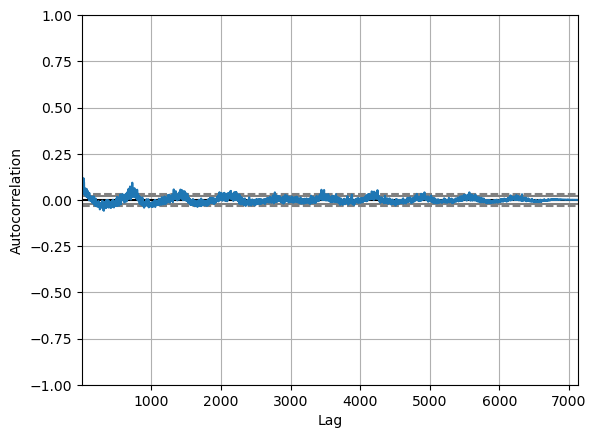

In [48]:
clean_rainfall_data = clean_data(rainfall_data, time_col="Date/Time (LST)", rain_col="Precip. Amount (mm)", remove_outliers=True)
inference(clean_rainfall_data, rain_col="Precip. Amount (mm)", using_decompose=False)

#### Hourly Rain no zeros + sigma limits

In [ ]:
# Initialize event_data as an empty DataFrame
rainfall_data = concat_data(data_folder)
clean_rainfall_data = clean_data(rainfall_data, time_col="Date/Time (LST)", rain_col="Precip. Amount (mm)", remove_outliers=True)
classed_data, sigma_limit = sigma_limits(clean_rainfall_data, rain_col="Precip. Amount (mm)", sigma=3)
inference_categorical(classed_data, rain_col="Rain Intensity")

# Plot all sigma classes
plt.figure(figsize=(15, 7))

# Define colors for sigma classes
colors = {'1 sigma': 'blue', '2 sigma': 'orange', '3 sigma': 'red'}

# Plot the data points with different colors based on their sigma class
for sigma_class, color in colors.items():
    if sigma_class == "No-Rainfall":
        continue
    subset = classed_data[classed_data['Rain Intensity'] == sigma_class]
    plt.scatter(subset.index, subset['Precip. Amount (mm)'], label=sigma_class, color=color, marker='x')
    
# Plot the mean line
mean = classed_data[classed_data["Precip. Amount (mm)"] > 0]["Precip. Amount (mm)"].mean()
plt.axhline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f} mm')

# Fill regions for low, moderate, and extreme rainfall
plt.fill_between(classed_data.index, 0, sigma_limit[0], color='green', alpha=0.2, label='Low Rainfall')
plt.fill_between(classed_data.index, sigma_limit[0], sigma_limit[1], color='yellow', alpha=0.2, label='Moderate Rainfall')
plt.fill_between(classed_data.index, sigma_limit[1], classed_data["Precip. Amount (mm)"].max(), color='red', alpha=0.2, label='Extreme Rainfall')

plt.title('Precipitation Amount by Sigma Class')
plt.xlabel('Date/Time (LST)')
plt.ylabel('Precip. Amount (mm)')
plt.legend()
plt.show()

### Machine Learning

#### Long short term memory (LSTM)

In [ ]:
## mlflow server and experiment parameters
mlflow.set_tracking_uri(uri="./mlruns")
mlflow.set_experiment("LSTM-Rainfall-Prediction")

# logging
with mlflow.start_run() as run:
    mlflow.keras.autolog()

    # LSTM model
    model, history, label_encoder, testing_data = train_lstm_model(classed_data, "Rain Intensity", 
                                                sequence_length=32, test_size=0.2,
                                                epochs=200, batch_size=25)
    
    # Plot training metrics
    fig = plot_training_metrics(history)
    mlflow.log_figure(fig, "training_metrics.png")
    
    # Confuseion matrix
    cm = model_confusion_matrix(model, *testing_data, label_encoder)
    mlflow.log_figure(cm, "confusion_matrix.png")

    # Plot rainfall category predictions
    fig = plot_rainfall_category_predictions(model, testing_data, label_encoder, horizon=24, event_index=6178)
    mlflow.log_figure(fig, "rainfall_category_predictions.png")

# run command <mlflow ui> in terminal to check the results

#### CNN

2025/06/16 16:42:21 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.12.1 <= tensorflow <= 2.19.0, but the installed version is 2.9.1. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


Computed Class Weights: {0: 3.3492351816443593, 1: 66.60266159695817, 2: 89.36989795918367, 3: 0.27209251751401897}
Epoch 1/3
701/701 [==============================] - 3s 5ms/step - loss: 1.3762 - precision: 0.8284 - recall: 0.0154 - val_loss: 1.3675 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
701/701 [==============================] - 3s 4ms/step - loss: 1.2971 - precision: 0.9731 - recall: 0.2496 - val_loss: 1.0968 - val_precision: 0.9719 - val_recall: 0.0395
Epoch 3/3
1/1 [==============================] - 0s 31ms/step


2025/06/16 16:42:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


INFO:tensorflow:Assets written to: /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmpgvz6hx_t/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmpgvz6hx_t/model/data/model/assets


1/1 [==============================] - 0s 11ms/step


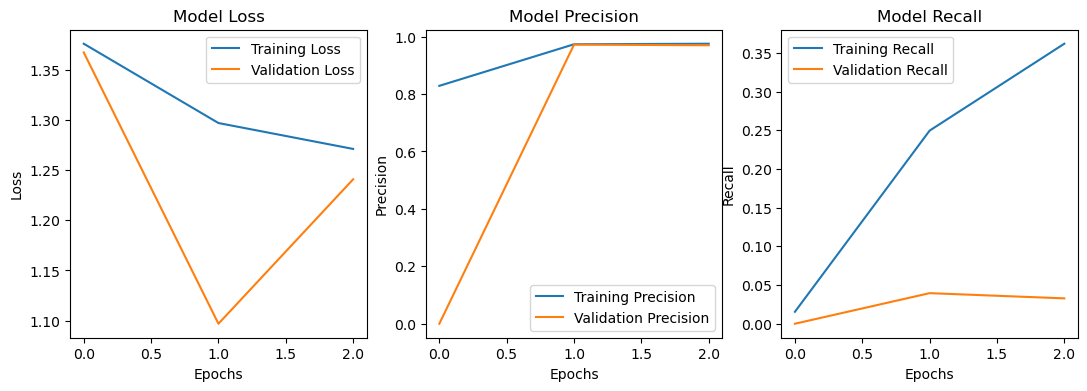

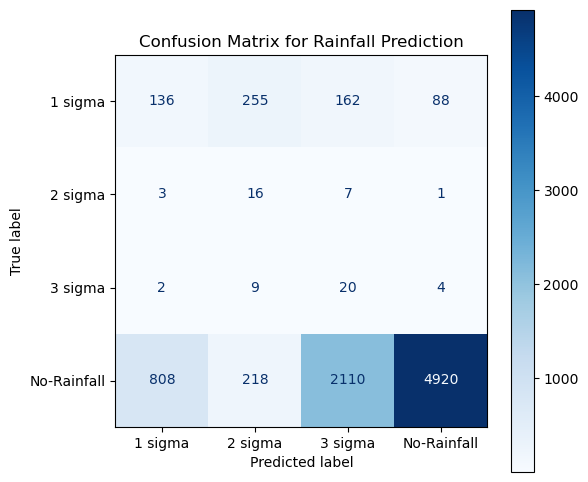

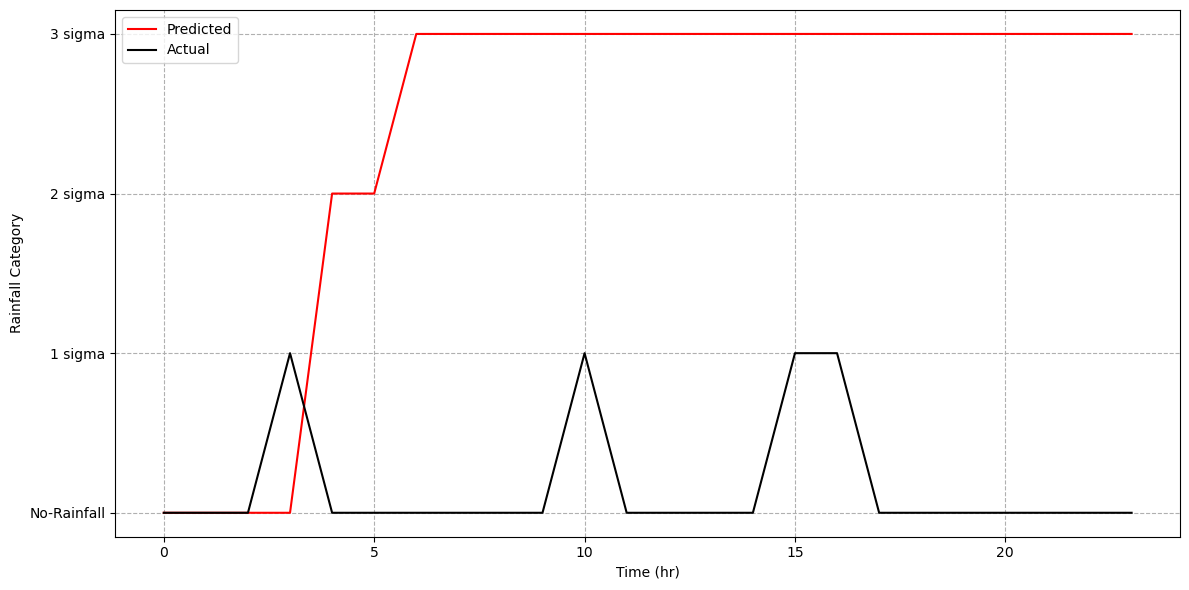

In [63]:
## mlflow server and experiment parameters
mlflow.set_tracking_uri(uri="./mlruns")
mlflow.set_experiment("CNN-Rainfall-Prediction")

# logging
with mlflow.start_run() as run:
    mlflow.keras.autolog()

    # CNN model
    model, history, label_encoder, testing_data = train_cnn_model(classed_data, "Rain Intensity",
                                                sequence_length=32, test_size=0.2,
                                                epochs=3, batch_size=100)
    
    # Plot training metrics
    fig = plot_training_metrics(history)
    mlflow.log_figure(fig, "training_metrics.png")
    
    # Confuseion matrix
    cm = model_confusion_matrix(model, *testing_data, label_encoder)
    mlflow.log_figure(cm, "confusion_matrix.png")

    # Plot rainfall category predictions
    fig = plot_rainfall_category_predictions(model, testing_data, label_encoder, horizon=24, event_index=6178)
    mlflow.log_figure(fig, "rainfall_category_predictions.png")

# run command <mlflow ui> in terminal to check the results

#### Random Forest

Classification Report:
               precision    recall  f1-score   support

     1 sigma       0.42      0.38      0.40       641
     2 sigma       0.03      0.26      0.05        27
     3 sigma       0.04      0.06      0.05        35
 No-Rainfall       0.96      0.94      0.95      8056

    accuracy                           0.90      8759
   macro avg       0.36      0.41      0.36      8759
weighted avg       0.92      0.90      0.91      8759



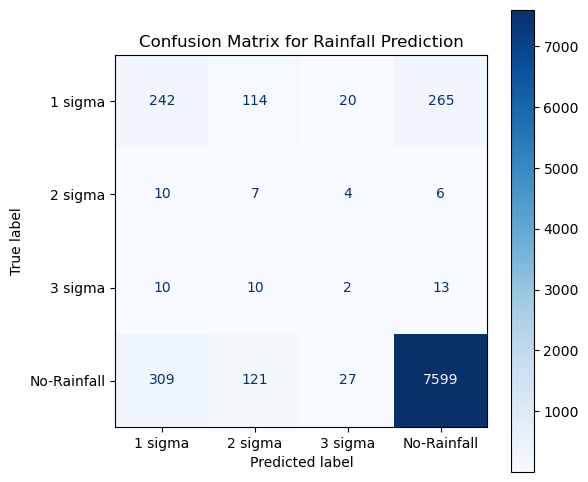

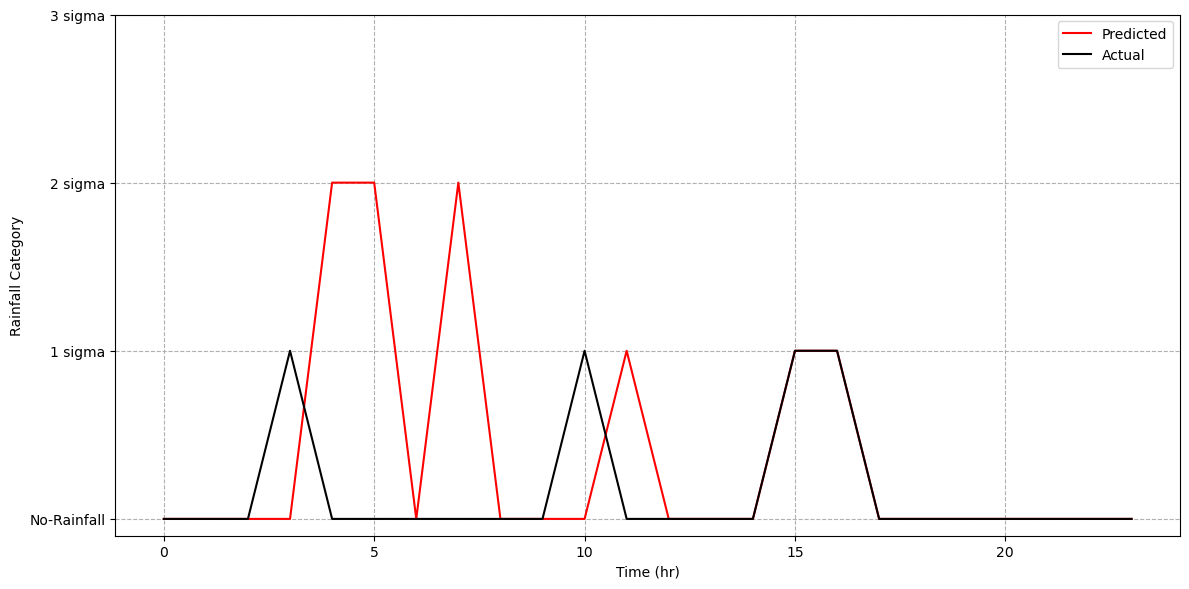

In [51]:
import mlflow
import mlflow.sklearn

## mlflow server and experiment parameters
mlflow.set_tracking_uri(uri="./mlruns")
mlflow.set_experiment("RF-Rainfall-Prediction")

# logging
with mlflow.start_run() as run:
    mlflow.sklearn.autolog()

    # RF model
    model, label_encoder, testing_data = train_tree_model(classed_data, "Rain Intensity", 
                                                          sequence_length=32, test_size=0.2)
    
    # Confuseion matrix
    cm = model_confusion_matrix(model, *testing_data, label_encoder, hot_encoding=False)
    mlflow.log_figure(cm, "confusion_matrix.png")

    # Plot rainfall category predictions
    fig = plot_rainfall_category_predictions(model, testing_data, label_encoder, horizon=24, event_index=6178, hot_encoding=False)
    mlflow.log_figure(fig, "rainfall_category_predictions.png")

# run command <mlflow ui> in terminal to check the results

## Publication Plot (PDF)

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

# Use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "font.size": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (15, 6)

### Classes Histogram

In [ ]:
data, rain_col = classed_data, "Rain Intensity"
# Frequency distribution of categorical data
freq_dist = data[rain_col].value_counts(normalize=True)

# Plot frequency distribution with dark colors and values on top of sigma 2 and sigma 3 classes
plt.figure(figsize=(7, 6))
bars = plt.bar(freq_dist.index, freq_dist.values, color=['black', 'dimgray', 'darkgray', 'gray'], width=0.5)
plt.xlabel(rain_col)
plt.ylabel('Proportion')

# Add values on top of sigma 2 and sigma 3 classes
for i, bar in enumerate(bars):
    height = bar.get_height()
    if bar.get_x() + bar.get_width() / 2 in [freq_dist.index.get_loc('2 sigma'), freq_dist.index.get_loc('3 sigma')]:
        plt.text(bar.get_x() + bar.get_width() / 2, height+0.01, f'{height:.3}', ha='center', va='bottom', color='black')

plt.savefig(Path(results_folder).joinpath("Rainfall_Frequency_Distribution.pdf"))

### Sigma Classification

In [ ]:
# Plot all sigma classes
plt.figure(figsize=(7, 6))

# Define colors for sigma classes
colors = {'1 sigma': 'blue', '2 sigma': 'orange', '3 sigma': 'red'}

# Filter data for the year 2024
classed_data_2024 = classed_data[classed_data['year'] == 2018]

# Plot the data points with different colors based on their sigma class
for sigma_class, color in colors.items():
    if sigma_class == "No-Rainfall":
        continue
    subset = classed_data_2024[classed_data_2024['Rain Intensity'] == sigma_class]
    plt.scatter(subset.index, subset['Precip. Amount (mm)'], color="lightgray", marker='.')

# Plot the mean line
mean = classed_data[classed_data["Precip. Amount (mm)"] > 0]["Precip. Amount (mm)"].mean()
plt.axhline(mean, color='r', linestyle='--', label=f'Mean={mean:.2f} mm/h')

# Fill regions for low, moderate, and extreme rainfall as horizontal lines
plt.axhline(y=sigma_limit[0], color='green', linestyle='-', linewidth=1)
plt.axhline(y=sigma_limit[1], color='darkgoldenrod', linestyle='-', linewidth=1)


x_pos = classed_data_2024.index.min()
x_pos_plus = classed_data_2024.index[250]

# Text annotations with bold text using `fontsize` and `weight`
# Add text annotations with bold text inside a box using `bbox`
plt.annotate(r'$\sigma$ (Low)', xy=(x_pos_plus, mean), xytext=(x_pos_plus, mean + 0.65),
             textcoords='data', color='green', ha='left', va='bottom',
             fontsize=14, weight='heavy', family='sans-serif',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white'))

plt.annotate(r'$2\sigma$ (Moderate)', xy=(x_pos_plus, sigma_limit[0]), xytext=(x_pos_plus, sigma_limit[0] + 0.65),
             textcoords='data', color='darkgoldenrod', ha='left', va='bottom',
             fontsize=14, weight='heavy', family='sans-serif',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='darkgoldenrod', facecolor='white'))

plt.annotate(r'$3 \sigma$ (Extreme)', xy=(x_pos_plus, sigma_limit[1]), xytext=(x_pos_plus, sigma_limit[1] + 3.5),
             textcoords='data', color='red', ha='left', va='bottom',
             fontsize=14, weight='heavy', family='sans-serif',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white'))


# Add vertical double-headed arrows between the axhlines and text
plt.annotate('', xy=(x_pos, mean), xytext=(x_pos, sigma_limit[0]),
             arrowprops=dict(arrowstyle='<|-|>', color='black'))
plt.annotate('', xy=(x_pos, sigma_limit[0]), xytext=(x_pos, sigma_limit[1]),
             arrowprops=dict(arrowstyle='<|-|>', color='black'))
plt.annotate('', xy=(x_pos, sigma_limit[1]), xytext=(x_pos, classed_data_2024["Precip. Amount (mm)"].max()),
             arrowprops=dict(arrowstyle='<|-|>', color='black'))


plt.xlabel('Time (hr)')
plt.xticks(ticks=plt.xticks()[0][::3])  # Reduce the number of tick labels by showing every 10th tick
plt.ylabel('Precipitation (mm/hr)')
plt.legend()

plt.savefig(Path(results_folder).joinpath("Rainfall_Sigma_Classes.pdf"))

### Loss

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(history.history['loss'], label='Training Loss', color='black', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='yellowgreen', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

plt.savefig(Path(results_folder).joinpath("LSTM_Loss.pdf"))

### Precision

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(history.history['precision'], label='Training Precision', color='black', linestyle='-')
plt.plot(history.history['val_precision'], label='Validation Precision', color='yellowgreen', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

plt.savefig(Path(results_folder).joinpath("LSTM_Precision.pdf"))

### Recall

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(history.history['recall'], label='Training Recall', color='black', linestyle='-')
plt.plot(history.history['val_recall'], label='Validation Recall', color='yellowgreen', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

plt.savefig(Path(results_folder).joinpath("LSTM_Recall.pdf"))

### Testing Model Predictions

In [ ]:
fig = plot_rainfall_category_predictions(model, testing_data, label_encoder, horizon=24, event_index=6178)

plt.savefig(Path(results_folder).joinpath("LSTM_Testing.pdf"))

In [ ]:
import mlflow.tensorflow

# Example: load from a run's artifact URI
model_uri = "runs:/7d8b2ed2183d4a27948423a2eba65178/model"

model_cnn = mlflow.tensorflow.load_model(model_uri)


In [58]:
model

1/1 [==============================] - 0s 10ms/step


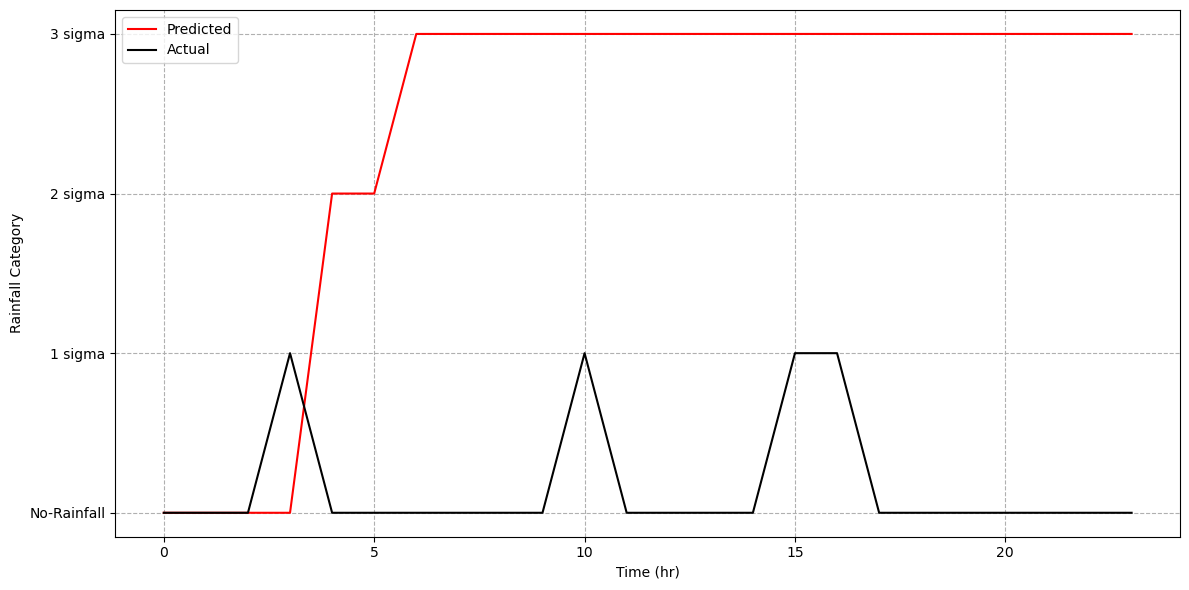

In [64]:
fig = plot_rainfall_category_predictions(model, testing_data, label_encoder, horizon=24, event_index=6178)
